In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras import backend as K
from keras import callbacks
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import layers, losses, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

In [3]:
folds = pd.read_csv("/Users/renitalewis/Downloads/archive/Folds.csv")
df = pd.DataFrame(folds.iloc[:7909])

In [5]:
df["label"] = df["filename"].apply(lambda x: x.split("/")[3])
df['label'] = df['label'].str.strip()

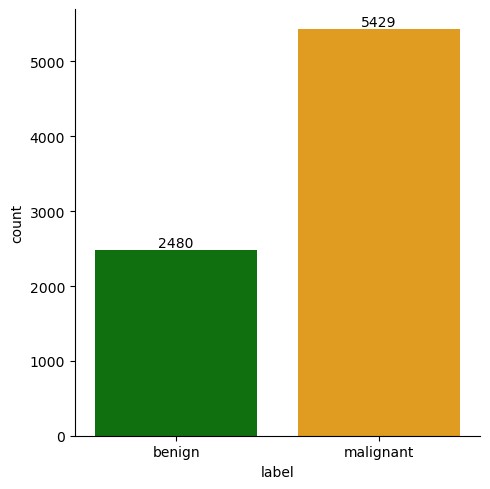

In [7]:
g = sns.catplot(x="label", data=df, kind="count", hue="label", palette=['green', 'orange'], legend=False)
for ax in g.axes.flat:
    for container in ax.containers:
        ax.bar_label(container)
plt.show()

In [9]:
df['label_int'] = df.label.apply(lambda x: ['benign', 'malignant'].index(x))

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df["filename"], df["label_int"], test_size=0.2, random_state=42)

In [13]:
def parse_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img, label

def resize_rescale(image, label):
    img = tf.cast(image, tf.float32)
    img = tf.image.resize(img, [224, 224]) / 255.0  
    return img, label

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

In [15]:
train_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_train, y_train))
test_loader = tf.data.Dataset.from_tensor_slices(("/Users/renitalewis/Desktop/ProjectFolder/archive/BreaKHis_v1/" + X_test, y_test))

In [17]:
# Applying data augmentation to the training dataset
X_trainset = train_loader.map(parse_image).map(augment_image).map(resize_rescale).shuffle(len(X_train)).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)
X_testset = test_loader.map(parse_image).map(resize_rescale).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

2024-07-26 16:27:18.080158: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 3082 of 6327
2024-07-26 16:27:28.080464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 6146 of 6327
2024-07-26 16:27:28.674805: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-07-26 16:27:28.935680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


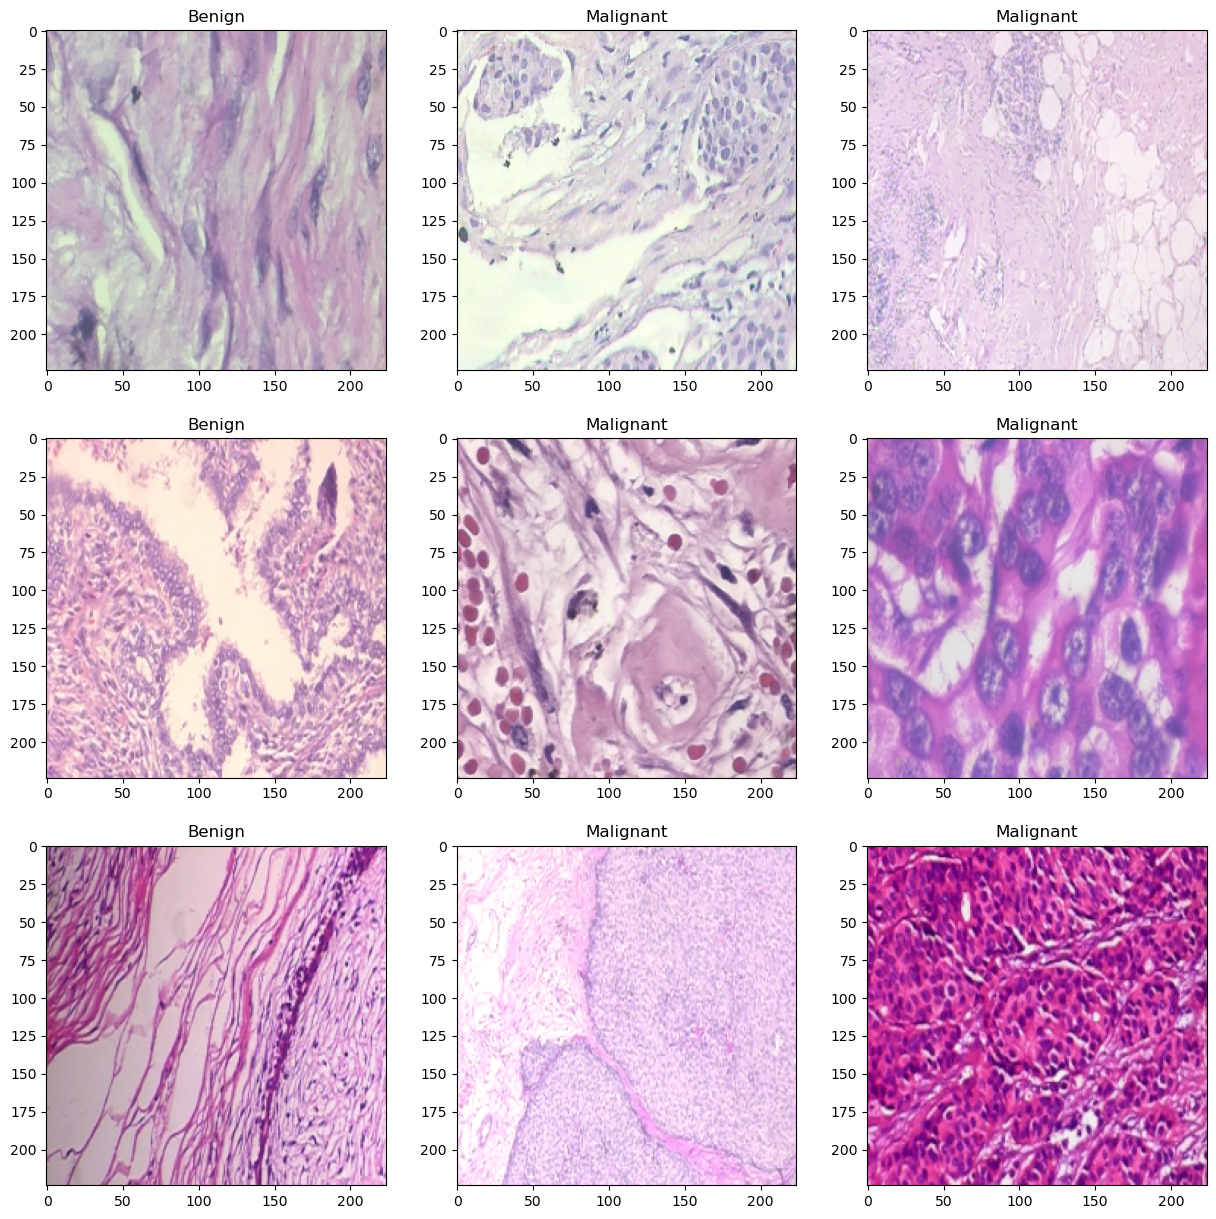

In [19]:
# Displaying the sample images
fig = plt.figure(figsize=(15, 15))
for images, labels in X_trainset.take(1):
    for i in range(9):
        ax = fig.add_subplot(3, 3, i + 1)
        if labels.numpy()[i] == 0:
            ax.title.set_text("Benign")
        else:
            ax.title.set_text("Malignant")
        plt.imshow(images.numpy()[i])
plt.show()

In [21]:
# Defining the model using VGG16
input_shape = (224, 224, 3)
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
base_model.trainable = False  # Freezing the base model

model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation="relu"),
    Dense(64, activation="relu"),
    Dense(2, activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.build(input_shape=(None, 224, 224, 3))  # Ensuring that the model is built before calling summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,751,810 (56.27 MB)

 Trainable params: 37,122 (145.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [23]:
def plotTrainingHistory(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['accuracy'], label='train')
    ax1.plot(history.history['val_accuracy'], label='validation')
    ax1.set_title('Accuracy')
    ax1.set_ylabel('The Accuracy score')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    ax2.plot(history.history['loss'], label='train')
    ax2.plot(history.history['val_loss'], label='validation')
    ax2.set_title('Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.show()

Epoch 1/25


2024-07-26 16:29:43.891304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 3147 of 6327
2024-07-26 16:29:54.019437: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 805s 8s/step - accuracy: 0.6176 - loss: 0.6540 - val_accuracy: 0.7807 - val_loss: 0.5151
Epoch 2/25


2024-07-26 16:43:08.014678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2798 of 6327
2024-07-26 16:43:18.017991: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5621 of 6327
2024-07-26 16:43:20.518795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 914s 9s/step - accuracy: 0.7582 - loss: 0.5121 - val_accuracy: 0.8123 - val_loss: 0.4441
Epoch 3/25


2024-07-26 16:58:22.097368: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2697 of 6327
2024-07-26 16:58:32.104928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5256 of 6327
2024-07-26 16:58:36.136049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 946s 9s/step - accuracy: 0.7768 - loss: 0.4654 - val_accuracy: 0.8154 - val_loss: 0.4237
Epoch 4/25


2024-07-26 17:14:08.502613: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2648 of 6327
2024-07-26 17:14:18.502957: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5368 of 6327
2024-07-26 17:14:22.161961: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 980s 10s/step - accuracy: 0.8059 - loss: 0.4290 - val_accuracy: 0.8508 - val_loss: 0.3735
Epoch 5/25


2024-07-26 17:30:28.616624: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2661 of 6327
2024-07-26 17:30:38.619429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5327 of 6327
2024-07-26 17:30:42.305568: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 1004s 10s/step - accuracy: 0.8168 - loss: 0.4135 - val_accuracy: 0.8477 - val_loss: 0.3697
Epoch 6/25


2024-07-26 17:47:12.571146: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2628 of 6327
2024-07-26 17:47:26.712282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 1050s 10s/step - accuracy: 0.8231 - loss: 0.3948 - val_accuracy: 0.8647 - val_loss: 0.3508
Epoch 7/25


2024-07-26 18:04:43.060289: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2522 of 6327
2024-07-26 18:04:59.218861: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 1034s 10s/step - accuracy: 0.8303 - loss: 0.3838 - val_accuracy: 0.8211 - val_loss: 0.3816
Epoch 8/25


2024-07-26 18:21:57.382874: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2505 of 6327
2024-07-26 18:22:07.390006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5087 of 6327
2024-07-26 18:22:12.229758: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 1031s 10s/step - accuracy: 0.8313 - loss: 0.3718 - val_accuracy: 0.8666 - val_loss: 0.3320
Epoch 9/25


2024-07-26 18:39:08.185186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2526 of 6327
2024-07-26 18:39:18.187658: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 4984 of 6327
2024-07-26 18:39:23.497074: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 1075s 11s/step - accuracy: 0.8458 - loss: 0.3567 - val_accuracy: 0.8445 - val_loss: 0.3569
Epoch 10/25


2024-07-26 18:57:02.897170: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2394 of 6327
2024-07-26 18:57:12.900413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 4837 of 6327
2024-07-26 18:57:18.846530: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 1017s 10s/step - accuracy: 0.8337 - loss: 0.3546 - val_accuracy: 0.8742 - val_loss: 0.3221
Epoch 11/25


2024-07-26 19:14:00.207138: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2595 of 6327
2024-07-26 19:14:14.284331: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 973s 10s/step - accuracy: 0.8474 - loss: 0.3428 - val_accuracy: 0.8616 - val_loss: 0.3296
Epoch 12/25


2024-07-26 19:30:13.678401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2513 of 6327
2024-07-26 19:30:28.267397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 983s 10s/step - accuracy: 0.8607 - loss: 0.3254 - val_accuracy: 0.8698 - val_loss: 0.3093
Epoch 13/25


2024-07-26 19:46:36.504118: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2602 of 6327
2024-07-26 19:46:46.505274: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5217 of 6327
2024-07-26 19:46:50.821242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 970s 10s/step - accuracy: 0.8404 - loss: 0.3503 - val_accuracy: 0.8755 - val_loss: 0.2976
Epoch 14/25


2024-07-26 20:02:46.064608: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2610 of 6327
2024-07-26 20:02:56.065550: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5254 of 6327
2024-07-26 20:03:00.112401: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 1036s 10s/step - accuracy: 0.8566 - loss: 0.3245 - val_accuracy: 0.8534 - val_loss: 0.3341
Epoch 15/25


2024-07-26 20:20:01.970400: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2123 of 6327
2024-07-26 20:20:11.972181: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 4190 of 6327
2024-07-26 20:20:22.480517: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 1027s 10s/step - accuracy: 0.8583 - loss: 0.3112 - val_accuracy: 0.8723 - val_loss: 0.3021
Epoch 16/25


2024-07-26 20:37:09.324725: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2632 of 6327
2024-07-26 20:37:23.274681: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 956s 9s/step - accuracy: 0.8688 - loss: 0.3071 - val_accuracy: 0.8723 - val_loss: 0.3017
Epoch 17/25


2024-07-26 20:53:05.703882: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2753 of 6327
2024-07-26 20:53:19.031746: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 910s 9s/step - accuracy: 0.8643 - loss: 0.3030 - val_accuracy: 0.8407 - val_loss: 0.3580
Epoch 18/25


2024-07-26 21:08:15.882367: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 2704 of 6327
2024-07-26 21:08:25.884209: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 5426 of 6327
2024-07-26 21:08:29.244428: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


99/99 ━━━━━━━━━━━━━━━━━━━━ 911s 9s/step - accuracy: 0.8677 - loss: 0.2967 - val_accuracy: 0.8066 - val_loss: 0.4177
25/25 ━━━━━━━━━━━━━━━━━━━━ 177s 7s/step - accuracy: 0.8716 - loss: 0.2966


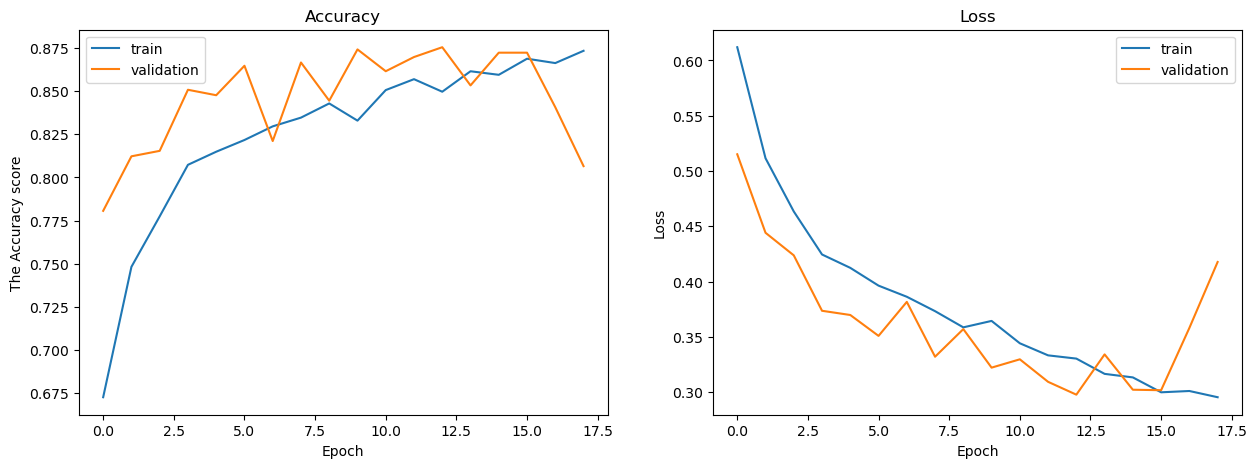

25/25 ━━━━━━━━━━━━━━━━━━━━ 190s 8s/step
              precision    recall  f1-score   support

      Benign       0.84      0.76      0.80       510
   Malignant       0.89      0.93      0.91      1072

    accuracy                           0.88      1582
   macro avg       0.86      0.85      0.85      1582
weighted avg       0.87      0.88      0.87      1582



2024-07-26 21:29:26.910262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<Axes: >

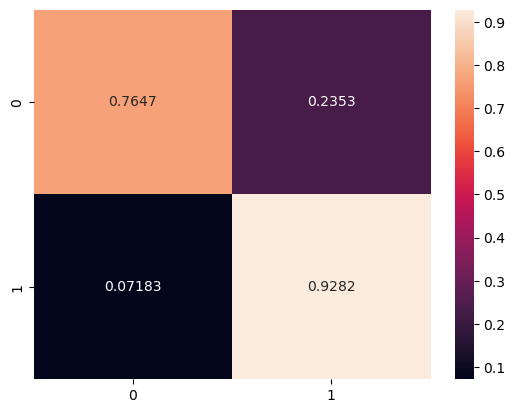

In [25]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}
earlystopping = callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True)
history = model.fit(X_trainset, epochs=25, verbose=1, validation_data=X_testset, callbacks=[earlystopping], class_weight=class_weights)
score = model.evaluate(X_testset)
plotTrainingHistory(history)
y_test_pred = model.predict(X_testset)
predicted_categories = tf.argmax(y_test_pred, axis=1)
true_categories = tf.concat([y for x, y in X_testset], axis=0)
print(classification_report(true_categories, predicted_categories, target_names=["Benign", "Malignant"]))
conf_mat = confusion_matrix(true_categories, predicted_categories, normalize='true')
sns.heatmap(conf_mat, annot=True, fmt='.4g')

25/25 ━━━━━━━━━━━━━━━━━━━━ 350s 14s/step


2024-07-26 22:10:53.003355: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


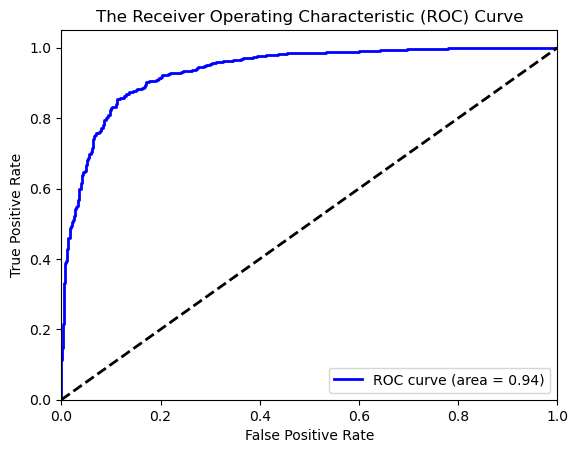

In [41]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test_pred_prob = model.predict(X_testset)

true_categories = np.concatenate([y for x, y in X_testset])
y_test_pred_prob_class1 = y_test_pred_prob[:, 1]

fpr, tpr, _ = roc_curve(true_categories, y_test_pred_prob_class1)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='blue', lw=lw, label='ROC curve (area = {0:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='k', linestyle='--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('The Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


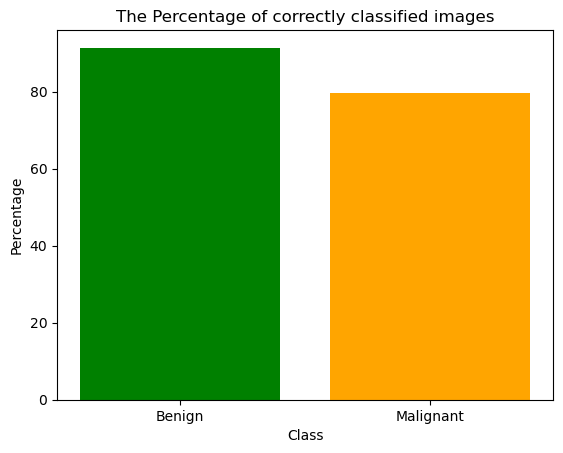

In [43]:
def plotScoresHist(conf_mat):
    scores = pd.DataFrame(conf_mat)
    classes = [0, 1]
    p = [scores[i].to_numpy()[i] / scores[i].to_numpy().sum() * 100 for i in classes]
    plt.bar(["Benign", "Malignant"], p, color=['green', 'orange'])
    plt.title("The Percentage of correctly classified images")
    plt.xlabel('Class')
    plt.ylabel('Percentage')
    plt.xticks(["Benign", "Malignant"])
    plt.show()

plotScoresHist(conf_mat)
